In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

pede_file = f"/sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF02T09V02.res.h5"
#pede_file = "/das/work/p17/p17983/Example_data/res/JF_pedestals/pedestal_20190707_1017.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [4]:
scan_name ="Febpy_monoscan_200mJ_5ps_001"
#scan_name =""

#DIR = "/sf/alvra/data/p17983/raw/solid_Ru/"
DIR = "/sf/alvra/data/p17589/raw/scan_data/" + scan_name + "/"
#DIR = f"/sf/alvra/data/{pgroup}/raw/"

DIR_json = f"/sf/alvra/data/p17589/res/scan_info/"

!ls -lah -t $DIR

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 785G
drwxrwsr-x. 138 17589 p17589  32K Jul  8 07:16 ..
drwxrwsr-x.   2 17589 p17589  32K Jul  7 10:18 .
-rw-r--r--.   1 root  p17589 163M Jul  7 10:18 Febpy_monoscan_200mJ_5ps_001_step0060.BSREAD.h5
-rw-r--r--.   1 root  p17589 163M Jul  7 10:17 Febpy_monoscan_200mJ_5ps_001_step0059.BSREAD.h5
-rw-r--r--.   1 root  p17589  61K Jul  7 10:17 Febpy_monoscan_200mJ_5ps_001_step0060.BSREAD_CA.h5
-rw-r--r--.   1 17589 p17589 8.8G Jul  7 10:17 Febpy_monoscan_200mJ_5ps_001_step0060.JF02T09V02.h5
-rw-r--r--.   1 root  p17589 163M Jul  7 10:17 Febpy_monoscan_200mJ_5ps_001_step0058.BSREAD.h5
-rw-r--r--.   1 17589 p17589 4.0G Jul  7 10:17 Febpy_monoscan_200mJ_5ps_001_step0060.JF06T04V01.h5
-rw-r--r--.   1 root  p17589  58K Jul  7 10:17 Febpy_monoscan_200mJ_5ps_001_step0059.BSREAD_CA.h5
-rw-r--r--.   1 17589 p17589 4.0G Jul  7 10:16 Febpy_monoscan_200mJ_5ps_001_step0059.JF06T04V01.h5
-rw-r--r--.   1 17589 p17589 8.8G Jul  7 10:16 Febpy_monoscan_200mJ_5ps_001_step0059.JF02T09V02.h5
-rw-r--r--.  

ra-c-002.psi.ch
There are 244 files in the folder /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/


/sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0060.JF02T09V02.h5
<HDF5 file "Febpy_monoscan_200mJ_5ps_001_step0060.JF02T09V02.h5" (mode r)>
[0 1 2 3 4 5 6 7 8]
(1000, 4608, 1024)
(514, 9318)


<IPython.core.display.Javascript object>


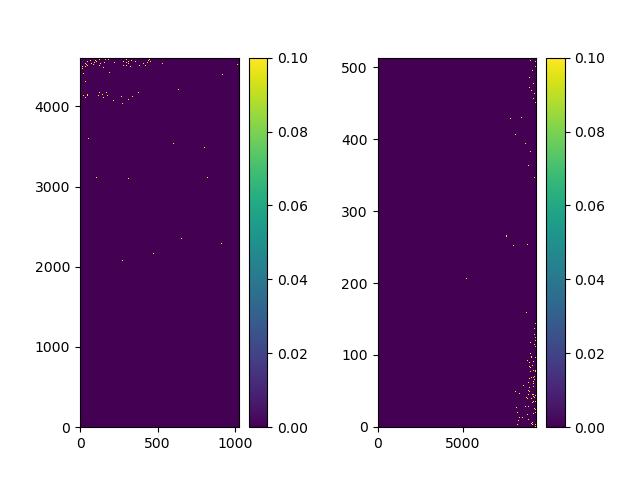

In [5]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

fileName = "Febpy_monoscan_200mJ_5ps_001_step0060.JF02T09V02.h5"
#fileName = "CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0015.JF02T09V01.h5"

print(DIR + fileName)

jf_file = h5py.File(DIR + fileName, "r")

print(jf_file)

images = jf_file[f"data/{detector_name}" + channel_JF_images]
pulse_ids = jf_file[f"data/{detector_name}" + channel_JF_pulse_ids]
try:
    module_maps = jf_file[f"/data/{detector_name}/module_map"]
except:
    module_maps = None

print(module_maps[0])
print(images.shape)

nframes = 10
#nframes = images.shape[0]
total = 0

for i in range(nframes):
    image = images[i, :]
    module_map = module_maps[i, :]
    image, mask = apply_module_map(image, module_map, mask)
    image = ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)#[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
    image_thr = image.copy()
    image_thr[image < 4] = 0
    total += image_thr
#total /= nframes
total_corr = ju.apply_geometry(total, detector_name)

print (total_corr.shape)

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
#roi = [[0, total_corr.shape[0]], [0, total_corr.shape[1]]]

plt.figure()
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.subplot(122)
plt.imshow(total_corr, origin="lower", aspect='auto', vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


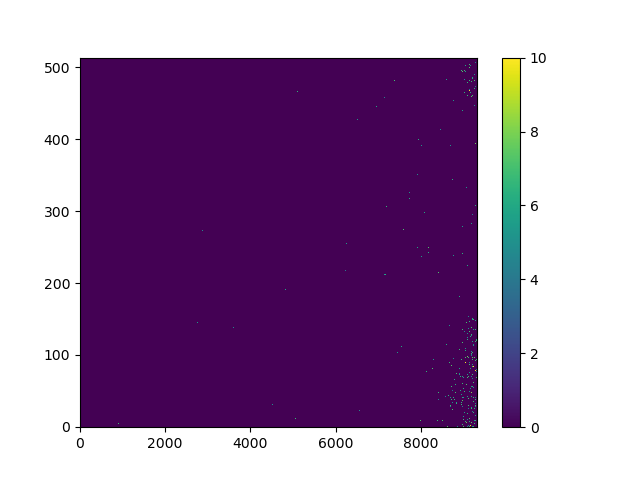

In [6]:
plt.figure()
plt.imshow(total_corr, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.colorbar()
plt.show()

# New script in the next cell (single file)

In [5]:
#files = ["Febpy_monoscan_200mJ_5ps_001_step0060"]
files = ["run_000042"]

roi1 = (7700, 7900, 200, 350)
roi2 = (6700, 7000, 100, 400)
threshold_low = 4
threshold_high = 10

######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
energy_eV = 0
        
for f in files:
    JF_single_file = DIR + f + ".JF02T09V02.h5"
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
#    photon_range = (6, 7)

    nshots = 100  # put this to None for ALL images
#     nshots = None

    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_data_on_off(JF_single_file, roi1, roi2, 50, 25, G=G, P=P, pixel_mask=mask, highgain=False, nshots=nshots)
    
#    Izero_pump, Izero_unpump, energy_eV, pulseIDs = \
#    load_FEL_pp_pulseID(BS_single_file, channel_energy, 50, 25, 50)  
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

#   images_ON_roi2[images_ON_roi2 < threshold_low] = 0
#   images_ON_roi2[images_ON_roi2 > threshold_high] = 0
#   images_ON_roi2 = convert_to_photon_num_range(images_ON_roi2)

    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
#   images_OFF_roi1 = convert_to_photon_num_range(images_OFF_roi1)


#   images_OFF_roi2[images_OFF_roi2 < threshold_low] = 0
#   images_OFF_roi2[images_OFF_roi2 > threshold_high] = 0
#   images_OFF_roi2 = convert_to_photon_num_range(images_OFF_roi2)

    spectrum_ON_roi1  = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2  = images_ON_roi2.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2.sum(axis = 1).sum(axis = 0)
    
print ("Job done! It took", round((time.time() - start_time), 2), "seconds to process", len(files), "file" if len(files) == 1 else "files")

Processing file /sf/alvra/data/p17983/raw/solid_Ru/run_000042.JF02T09V02.h5
Will apply module map: [-1 -1 -1  0  1  2  3  4  5]
Job done! It took 16.29 seconds to process 1 file


<IPython.core.display.Javascript object>


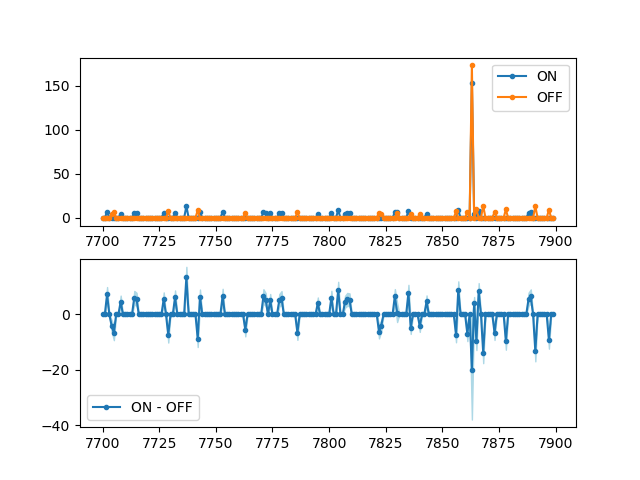

In [6]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[0], roi1[1])

spectra_on_rebin1  = bin_sum(spectra_on,  bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
#plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

# New script in the next cell (scans) 

In [7]:
scan_name = "Febpy_monoscan_200mJ_5ps_001"          # you need to change only this name

roi1 = (7700, 7900, 200, 350)
roi2 = (6700, 7000, 100, 400)
threshold_low = 4
threshold_high = 10

######################################################################################

fname_scan = DIR_json + scan_name + "_scan_info.json"
scan_data = load_scan_data(fname_scan)

Energy_eV = []
Delay_mm = []
XAS_trans_roi1 = []
Error_XAS_roi1 = []
XAS_trans_roi2 = []
Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []

clock = Clock()
num_scan_files = len(scan_data)
print("\nProcessing", num_scan_files, "files total")

for i, (bs, fn, _) in enumerate(scan_data):
    print("\nFile", i+1, "of", num_scan_files, ": Processing:", fn.split("/")[-1])
    
    spectrum_ON_roi1 = 0
    spectrum_OFF_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0
    
    nshots = 100  # put this to None for ALL images
    #nshots = None
    
    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_data_on_off(fn, roi1, roi2, 50, 25, G=G, P=P, pixel_mask=mask, highgain=False, nshots=nshots)
    
    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
    energy = [x for x in energy if (x > 0)]
    Energy_eV.append(np.mean(energy))
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
    
    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
    
    images_ON_roi2_thr = images_ON_roi2.copy()
    images_ON_roi2_thr[images_ON_roi2 < threshold_low] = 0
    images_ON_roi2_thr[images_ON_roi2 > threshold_high] = 0
    
    images_OFF_roi2_thr = images_OFF_roi2.copy()
    images_OFF_roi2_thr[images_OFF_roi2 < threshold_low] = 0
    images_OFF_roi2_thr[images_OFF_roi2 > threshold_high] = 0
    
    spectrum_ON_roi1 = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_ON_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_trans_roi1.append(np.abs(spectrum_ON_roi1 - spectrum_OFF_roi1).sum())
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
    
    print ("It took", clock.tick(), "seconds to process this file")

Energy_eV = np.array(Energy_eV)
XAS_trans_roi1 = np.array(XAS_trans_roi1)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")




Processing 61 files total

File 1 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0000.JF02T09V02.h5
All modules are active


/sf/alvra/anaconda/dev/lib/python3.6/site-packages/jungfrau_utils/corrections.py:202: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  res = np.stack(partial_func_to_use(i) for i in image)


It took 11.36 seconds to process this file

File 2 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0001.JF02T09V02.h5
All modules are active
It took 11.09 seconds to process this file

File 3 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0002.JF02T09V02.h5
All modules are active
It took 11.28 seconds to process this file

File 4 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0003.JF02T09V02.h5
All modules are active
It took 10.99 seconds to process this file

File 5 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0004.JF02T09V02.h5
All modules are active
It took 11.5 seconds to process this file

File 6 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0005.JF02T09V02.h5
All modules are active
It took 10.77 seconds to process this file

File 7 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0006.JF02T09V02.h5
All modules are active
It took 11.05 seconds to process this file

File 8 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0007.JF02T09V02.h5
Al

All modules are active
It took 10.68 seconds to process this file

File 58 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0057.JF02T09V02.h5
All modules are active
It took 10.44 seconds to process this file

File 59 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0058.JF02T09V02.h5
All modules are active
It took 10.85 seconds to process this file

File 60 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0059.JF02T09V02.h5
All modules are active
It took 10.69 seconds to process this file

File 61 of 61 : Processing: Febpy_monoscan_200mJ_5ps_001_step0060.JF02T09V02.h5
All modules are active
It took 10.8 seconds to process this file

Job done! It took 666.71 seconds to process 61 file(s)


<IPython.core.display.Javascript object>


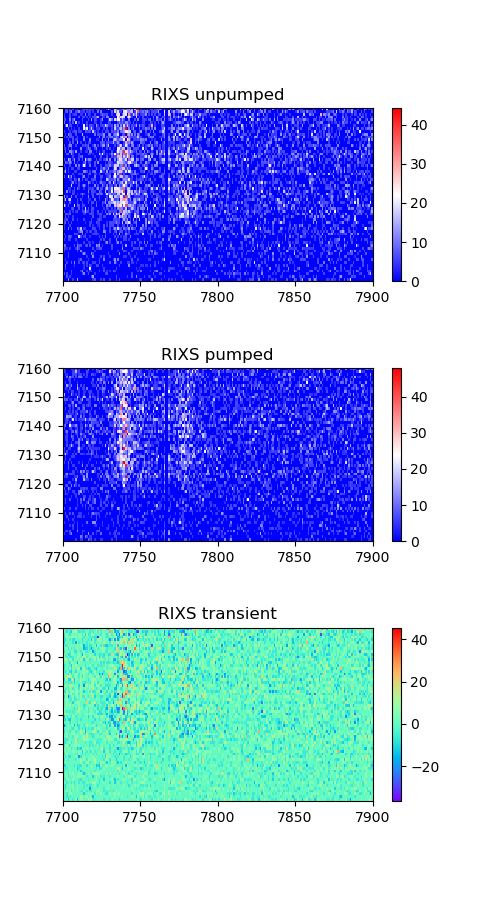

In [8]:
plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "rainbow", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


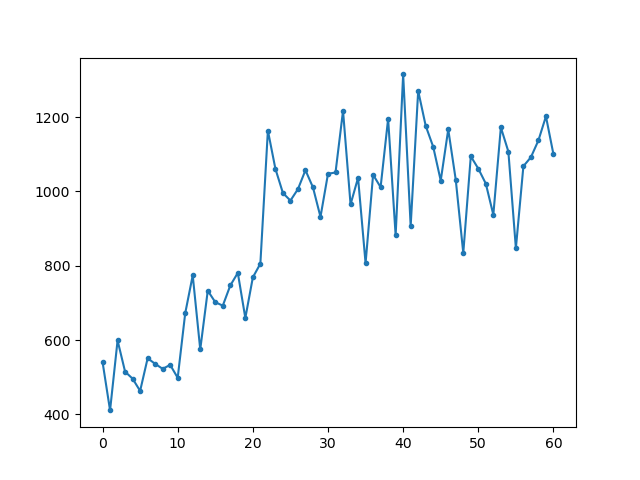

<function matplotlib.pyplot.show(*args, **kw)>

In [9]:
plt.figure()
plt.plot(XAS_trans_roi1, label="", marker='.')
plt.show

# Next cells: old code (still works...)

# Set the ROIs (roi1 & roi2 in pixels) in the next cell

In [ ]:
# Ka emission 
roi1 = [[250, 300], [8000, 9050]] # change these numbers, here they are for both crystals1 (up & down) overlapped
#roi1 = [[7030, 7130], [220, 290]]
#roi1 = [[100, 200], [8000, 9000]]

# Kb emission 
roi2 = [[100, 400], [6700, 7000]] # change these numbers, here they are for both crystals2 (up & down) overlapped

##################################################################

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

# The next cell is to analyse a single file or a series of identical ones to be summed up

In [ ]:
#files = ["Kalpha_Fe_foil_8keV_0.1trans_3"]          # you need to change only this name
#files = ["CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0019","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0020","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0022","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0023"]

files = ["run_000004"]
######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
energy_eV = 0
        
for f in files:
    
    JF_single_file = DIR + f + ".JF02T09V02.h5"
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
    (image_ON, image_OFF, pulseIDs) = load_JF_data_OnOff_pulseID(str(JF_single_file), 50, 25)
    
    nframes_ON = np.ma.size(image_ON,0)
    nframes_OFF = np.ma.size(image_OFF,0)
    print (nframes_ON, nframes_OFF)
#    threshold = 2
#    threshold_low = 3 
#    threshold_high = 7
    #photon_range = (6, 7)
    
    for j in range(nframes_ON):
        
        image_ON_2D = image_ON[j,:,:]
        image_ON_2D = ju.apply_gain_pede(image_ON_2D, G=G, P=P, pixel_mask=mask, highgain=False)
        image_ON_2D_corr = ju.apply_geometry(image_ON_2D, detector_name)
        image_ON_2D_roi1 = image_ON_2D_corr[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_ON_2D_roi2 = image_ON_2D_corr[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
#        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
#        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
#        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
#        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0

#        image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
#        image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)

#        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
        spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)#/Izero_pump[j]
        spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)#/Izero_pump[j]
    
        image_OFF_2D = image_OFF[j,:,:]
        image_OFF_2D = ju.apply_gain_pede(image_OFF_2D, G=G, P=P, pixel_mask=mask, highgain=False)
        image_OFF_2D_corr = ju.apply_geometry(image_OFF_2D, detector_name)
        image_OFF_2D_roi1 = image_OFF_2D_corr[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_OFF_2D_roi2 = image_OFF_2D_corr[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
#        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
#        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
#        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
#        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0

#        image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
#        image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)

#        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
        spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)#/Izero_pump[j]
        spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)#/Izero_pump[j]
    
        
print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",np.size(files),"file(s)")


In [ ]:
roi1 = [[250, 300], [8000, 9050]]

bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

spectra_on_rebin1 = bin_sum(spectra_on, bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
#plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
#plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

In [ ]:
import h5py
from matplotlib import pyplot as plt

fn = "/sf/alvra/data/p17983/res/cropped_data/TPA_Fe/run_000044.JF02T09V02crop.h5"
with h5py.File(fn) as f:
    images = f["images"][:]

total = images.mean(axis=0)

In [ ]:
plt.figure()
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=0.07)
plt.show()